# K-nearest neighbour classifier

In [4]:
import numpy as np

When developing algorithms it is often desirable to have datasets for testing purposes. When there is no access to a suitable dataset, sometimes it is convenient to generate synthetic data. In this tutorial, we will  
1. create synthetic datasets consisting of two classes of objects;
2. develop the k-NN algorithm;
3. evaluate the algorithm's ability to separate the two classes of objects.

## Excercise 1. Create synthetic dataset

We would like to generate training and validation datasets for binary classification. For visualisation purposes, we will assume that our objects have 2 numeric features. We would like to generate 2 "cloulds" of points on the plane corresponding to the positive and negative objects respectively. To do this, one can generate random points from a [multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) (function $\texttt{np.random.multivariate_normal}$). For example, $\texttt{np.random.multivariate_normal([a,b], [[1,0],[0,1]], N)}$ will generate a set on N points scattered around the *mean* point $(a,b)$.

1. Create two sets of $N=10$ points. The first set scattered around the point $(0,0)$ and the second scattered around the point $(2,2)$. These sets of points will correspond to the positive and the negative class respectively.

In [5]:
N = 10

In [6]:
import matplotlib.pyplot as plt

2. Plot the generated sets of points. Use different colours or markers for different classes.

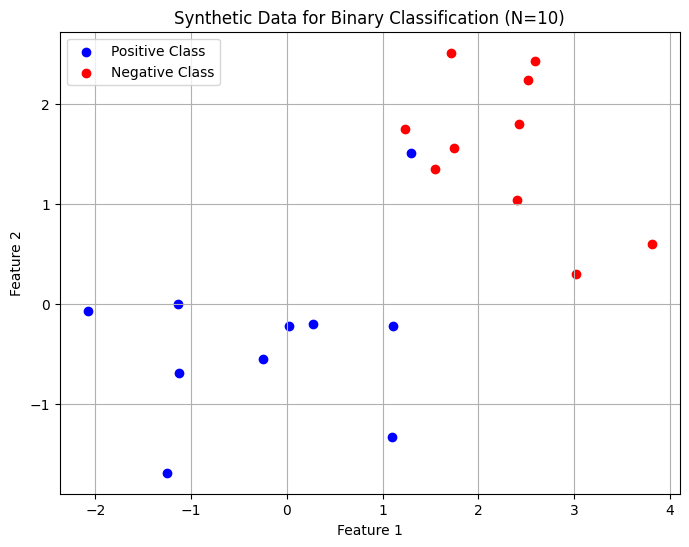

In [7]:
# 更新均值向量以反映新的需求
mean_positive_new = [0, 0]
mean_negative_new = [2, 2]

# 定义协方差矩阵
covariance_matrix = [[1, 0], [0, 1]]

# 生成新的正类和负类的数据点
points_positive_new = np.random.multivariate_normal(mean_positive_new, covariance_matrix, N)
points_negative_new = np.random.multivariate_normal(mean_negative_new, covariance_matrix, N)

# 可视化新生成的数据点
plt.figure(figsize=(8, 6))
plt.scatter(points_positive_new[:, 0], points_positive_new[:, 1], c='blue', label='Positive Class')
plt.scatter(points_negative_new[:, 0], points_negative_new[:, 1], c='red', label='Negative Class')
plt.title('Synthetic Data for Binary Classification (N=10)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.grid(True)
plt.show()

3. Split each of the sets into equal train and validation portions. As a result you should have four sets:
- positive object in the train dataset;
- positive object in the validation dataset;
- negataive object in the train dataset;
- negataive object in the validation dataset;

To confirm that the sets have equal numbers of objects, print the number of elements in each set.

In [8]:
# 将每个类别的数据集分为等大小的训练和验证部分
split_index = N // 2  # 由于N=10，分割索引为5，确保等分数据
print(split_index) # 两个 // 代表整除, 否则结果是5.0

# 正类数据集的分割
train_positive = points_positive_new[:split_index]
validation_positive = points_positive_new[split_index:]

# 负类数据集的分割
train_negative = points_negative_new[:split_index]
validation_negative = points_negative_new[split_index:]

# 打印每个集合中的元素数量
len_train_positive = len(train_positive)
len_validation_positive = len(validation_positive)
len_train_negative = len(train_negative)
len_validation_negative = len(validation_negative)

len_train_positive, len_validation_positive, len_train_negative, len_validation_negative


5


(5, 5, 5, 5)

4. Add an extra freature (representing the class label: +1 for the positive class, -1 for the negative class) to the train and validation instances. As a result you will have two datasets, each consisting of tuples (label, instance).

In [9]:
# 为训练和验证实例添加额外的特征（类标签）
# 正类标签为+1，负类标签为-1

# 添加标签并合并训练数据
train_with_labels = np.concatenate([
    np.hstack([train_positive, np.ones((len(train_positive), 1))]),  # 正类标签+1
    np.hstack([train_negative, -np.ones((len(train_negative), 1))])  # 负类标签-1
])

# 添加标签并合并验证数据
validation_with_labels = np.concatenate([
    np.hstack([validation_positive, np.ones((len(validation_positive), 1))]),  # 正类标签+1
    np.hstack([validation_negative, -np.ones((len(validation_negative), 1))])  # 负类标签-1
])

# 确认结果的形状
train_with_labels.shape, validation_with_labels.shape


((10, 3), (10, 3))

>我们已经为训练和验证实例添加了一个额外的特征，用于表示类标签（正类为+1，负类为-1）。结果是，我们现在有两个数据集，每个数据集都由元组(label, instance)组成：
>
>训练数据集包含10个实例，每个实例现在有3个特征（两个原始特征加上一个类标签特征）。
>验证数据集也包含10个实例，每个实例同样有3个特征。
>这样，每个数据点现在都包括其特征值以及对应的类标签，为接下来的分类任务做好了准备。

## Excercise 2. Develop the k-NN algorithm

Implement k-NN prediction function that uses the training dataset from the previous exercise. Use cosine similarity as a "measure of distance". The larger the similarity between two objects, the closer the objects are to each other.

1. Create the cosine similarity function that will be used in the k-NN prediction function to find the neighbours. The function should take two vectors as input and output the cosine similarity between the vectors.

In [10]:
def cosine_similarity(v1, v2):
    """计算两个向量之间的余弦相似度。
    
    参数:
    - v1: 第一个向量。
    - v2: 第二个向量。
    
    返回:
    - 两个向量之间的余弦相似度。
    """
    # 计算两个向量的点积
    dot_product = np.dot(v1, v2)
    # 计算两个向量的模
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    # 计算余弦相似度
    similarity = dot_product / (norm_v1 * norm_v2)
    return similarity

# 示例：计算两个向量之间的余弦相似度
v1 = np.array([1, 2, 3])
v2 = np.array([4, 5, 6])

cosine_similarity_example = cosine_similarity(v1, v2)
cosine_similarity_example


0.9746318461970762

2. Implement a function that predicts the class of a validation instance using the k-NN algorithm. The function should take a validation instance and the parameter $k$ as input, and output predicted class of the validation instance (+1 or -1).

In [11]:
# 使用之前定义的余弦相似度函数和生成的数据集来实现k-NN预测函数
def kNN_predict_cosine(validation_instance, train_data, k):
    # 计算验证实例与每个训练实例之间的余弦相似度
    similarities = np.array([cosine_similarity(validation_instance, instance[:-1]) for instance in train_data])
    
    # 找出k个最相似（最近邻）实例的索引
    k_nearest_indices = np.argsort(similarities)[-k:]
    
    # 获取这些最近邻的类标签，并进行投票
    k_nearest_labels = train_data[k_nearest_indices, -1]
    predicted_class = 1 if np.sum(k_nearest_labels) > 0 else -1
    
    return predicted_class

# 选择一个验证实例进行预测
validation_instance = validation_with_labels[0, :-1]  # 选择第一个验证实例的特征
predicted_class = kNN_predict_cosine(validation_instance, train_with_labels, k=3)  # 使用k=3进行预测

predicted_class



1

## Excercise 3. Evaluate the algorithm

1. Implement $\texttt{kNNaccuracy}$ function that takes the parameter $k$ and the validation dataset as input and output the accuracy of the k-NN algorithm on the validation dataset. Use the function to compute the accuracy of prediciton of the k-NN classifier on the validation dataset, when $k = 5$.

In [12]:
def kNN_accuracy(k, validation_data, train_data):
    """计算k-NN算法在验证数据集上的准确率。
    
    参数:
    - k: 用于k-NN的邻居数。
    - validation_data: 验证数据集，包括特征和类别标签。
    - train_data: 训练数据集，包括特征和类别标签。
    
    返回:
    - k-NN算法的准确率。
    """
    correct_predictions = 0
    total_predictions = len(validation_data)
    
    for instance in validation_data:
        # 预测每个验证实例的类别
        predicted_class = kNN_predict_cosine(instance[:-1], train_data, k)
        # 检查预测类别是否与真实类别相同
        if predicted_class == instance[-1]:
            correct_predictions += 1
    
    # 计算准确率
    accuracy = correct_predictions / total_predictions
    return accuracy

# 使用k=5计算k-NN分类器在验证数据集上的准确率
k = 5
accuracy_kNN = kNN_accuracy(k, validation_with_labels, train_with_labels)
accuracy_kNN


0.9

2. Generate new datasets with $N=100$. Compute accuracies of k-NN for all odd $k$ from 1 to 99. Plot k-NN accuracy versus $k$. What is the best value of $k$ for the validation dataset?

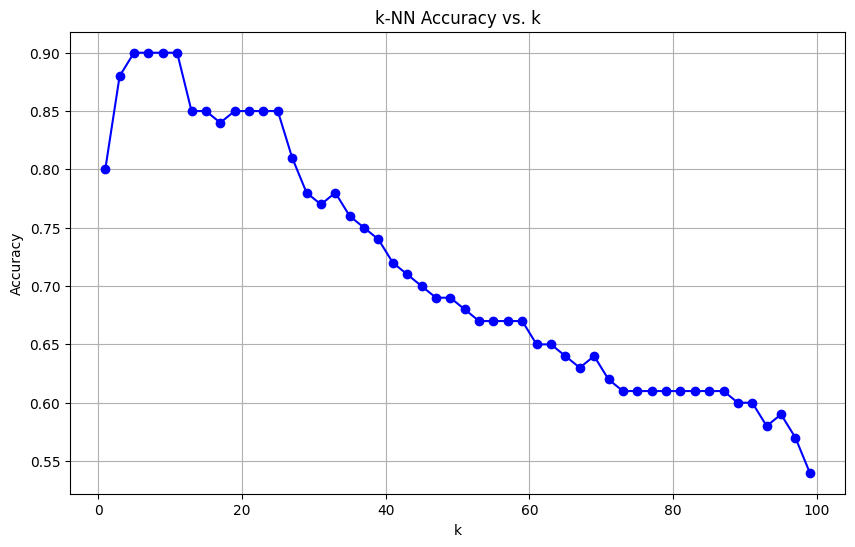

(5, 0.9)

In [15]:
# 生成新的数据集，N=100
N = 100
points_positive_new = np.random.multivariate_normal(mean_positive_new, covariance_matrix, N)
points_negative_new = np.random.multivariate_normal(mean_negative_new, covariance_matrix, N)

# 分割数据为训练和验证集
train_positive = points_positive_new[:N//2]
validation_positive = points_positive_new[N//2:]
train_negative = points_negative_new[:N//2]
validation_negative = points_negative_new[N//2:]

# 为训练和验证实例添加类标签
train_with_labels = np.concatenate([
    np.hstack([train_positive, np.ones((len(train_positive), 1))]),
    np.hstack([train_negative, -np.ones((len(train_negative), 1))])
])

validation_with_labels = np.concatenate([
    np.hstack([validation_positive, np.ones((len(validation_positive), 1))]),
    np.hstack([validation_negative, -np.ones((len(validation_negative), 1))])
])

# 计算k-NN对于所有奇数k从1到99的准确率
k_values = range(1, 100, 2)  # 奇数k值
accuracies = [kNN_accuracy(k, validation_with_labels, train_with_labels) for k in k_values]

# 找出准确率最高的k值
best_k = k_values[np.argmax(accuracies)]
best_accuracy = max(accuracies)

# 绘制k-NN准确率与k的关系图
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='blue')
plt.title('k-NN Accuracy vs. k')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

best_k, best_accuracy


3. Conduct further experiments:
    * change the value of $k$
    * increase the number of instances $N$ (make sure that $N$ is even)
    * separate or bring together the two classes by adjusting the means of the two Gaussians.

How does the accuracy vary in each case?

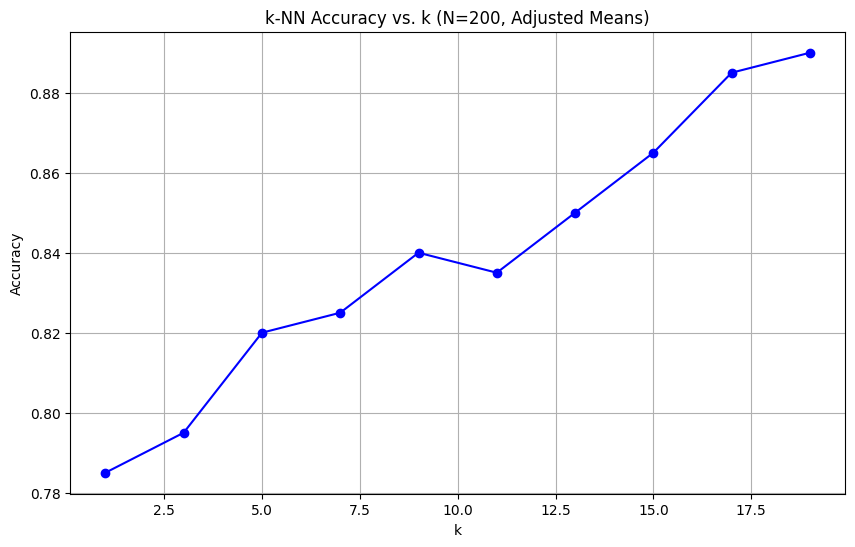

(19, 0.89)

In [20]:
# 重新导入必要的库，重新定义所需函数和变量，因为代码执行状态已重置
import numpy as np
import matplotlib.pyplot as plt

def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    similarity = dot_product / (norm_v1 * norm_v2)
    return similarity

def kNN_predict_cosine(validation_instance, train_data, k):
    similarities = np.array([cosine_similarity(validation_instance, instance[:-1]) for instance in train_data])
    k_nearest_indices = np.argsort(similarities)[-k:]
    k_nearest_labels = train_data[k_nearest_indices, -1]
    predicted_class = 1 if np.sum(k_nearest_labels) > 0 else -1
    return predicted_class

def kNN_accuracy(k, validation_data, train_data):
    correct_predictions = 0
    for instance in validation_data:
        predicted_class = kNN_predict_cosine(instance[:-1], train_data, k)
        if predicted_class == instance[-1]:
            correct_predictions += 1
    accuracy = correct_predictions / len(validation_data)
    return accuracy

# 生成新的数据集参数
N = 200
mean_positive_updated = [0, 0]
mean_negative_updated = [2, 2]
covariance_matrix = [[1, 0], [0, 1]]

np.random.seed(0)
points_positive_updated = np.random.multivariate_normal(mean_positive_updated, covariance_matrix, N)
points_negative_updated = np.random.multivariate_normal(mean_negative_updated, covariance_matrix, N)

# 分割数据为训练和验证集
train_positive_updated = points_positive_updated[:N//2]
validation_positive_updated = points_positive_updated[N//2:]
train_negative_updated = points_negative_updated[:N//2]
validation_negative_updated = points_negative_updated[N//2:]

train_with_labels_updated = np.concatenate([
    np.hstack([train_positive_updated, np.ones((len(train_positive_updated), 1))]),
    np.hstack([train_negative_updated, -np.ones((len(train_negative_updated), 1))])
])

validation_with_labels_updated = np.concatenate([
    np.hstack([validation_positive_updated, np.ones((len(validation_positive_updated), 1))]),
    np.hstack([validation_negative_updated, -np.ones((len(validation_negative_updated), 1))])
])

# 计算k-NN准确率
k_values_updated = range(1, 20, 2)
accuracies_updated = [kNN_accuracy(k, validation_with_labels_updated, train_with_labels_updated) for k in k_values_updated]

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(k_values_updated, accuracies_updated, marker='o', linestyle='-', color='blue')
plt.title('k-NN Accuracy vs. k (N=200, Adjusted Means)')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# 找出最佳k值
best_k_updated = k_values_updated[np.argmax(accuracies_updated)]
best_accuracy_updated = max(accuracies_updated)

best_k_updated, best_accuracy_updated
